# 第一题

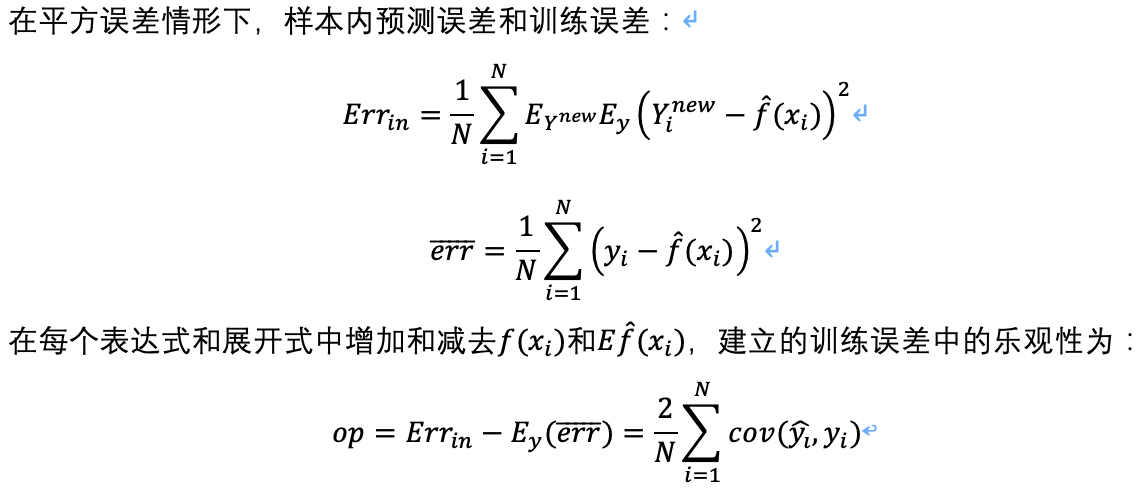

$\overline{err}=\frac{1}{N}\sum\limits_{i=1}^{N}(y_i-f(x_i)+f(x_i)-E\hat{f}(x_i)+E\hat{f}(x_i)-\hat{f}(x_i))\\ =\frac{1}{N}[\sum(y_i-f(x_i))^2+\sum(f(x_i)-E\hat{f}(x_i))^2+\sum(E\hat{f}(x_i)-\hat{f}(x_i))+2\sum(f(x_i)-E\hat{f}(x_i))(E\hat{f}(x_i)-\hat{f}(x_i))]\\ =:\frac{1}{N}（a_1+b+c+d_1+e_1+f）\\ 同理：\frac{1}{N}\sum\limits_{i=1}^{N}(Y_i^{new}-\hat{f}(x_i))^2=\frac{1}{N}(a_2+b+c+d_2+e_2+f)\\其中：a_2=\sum E_{Y^{new}}(Y_{i}^{new}-f(x_i))^2,d_2=2\sum E_{Y^{new}}(Y_i^{new}-f(x_i))(f(x_i)-E\hat{f}(x_i))\\
e_2=2\sum E_{Y^{new}}(Y_i^{new}-f(x_i))(E\hat{f}(x_i)-\hat{f}(x_i))$

抱歉，下面因为能力不够，没有做出来

# 第二题

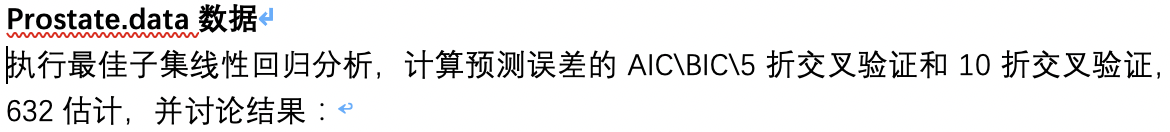

选择线性回归变量子集的直接方法是尝试所有可能的组合，并选择一个最小化某些标准的组合。这就是最佳子集回归的目标。对于每个k∈{1,2，...，p}，其中p是可用特征的总数，它选择大小为k的子集，其给出最小的残差平方和。然而，平方和不能用作确定k本身的标准，因为它必然随k减小：模型中包含的变量越多，其残差越小。但这并不能保证更好的预测性能。这就是为什么应该使用另一个标准来选择最终模型的原因。对于专注于预测的模型，测试数据上的（可能是交叉验证的）错误是常见的选择。

In [70]:
#读取数据
import pandas as pd
import numpy as np
import itertools
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_iris 
from sklearn.model_selection import train_test_split 
import sklearn
# K折交叉验证模块
from sklearn.model_selection import cross_val_score 
import warnings
warnings.filterwarnings("ignore") 

data = pd.read_csv('../data/prostate.txt',
                   header=0,sep='\t',encoding='utf-8',index_col=0)
X = np.array(data.iloc[:,[i for i in range(0,8)]])
Y = np.array(data['lpsa'])

# X_train = np.array(data[data['train']=='T'].iloc[:,[i for i in range(0,8)]])
# X_test = np.array(data[data['train']=='F'].iloc[:,[i for i in range(0,8)]])
# Y_train = np.array(data[data['train']=='T']['lpsa'])
# Y_test = np.array(data[data['train']=='F']['lpsa'])


包含K折交叉验证的最佳子集回归，验证统计量包括：AIC，BIC，平均绝对误差

In [76]:
def K_folds_regression(X,Y,K):
    results = pd.DataFrame(columns=['num_features', 'features', 'MAE'])
#     ,'AIC','BIC'
    for k in range(1, X.shape[1] + 1):
        # Loop over all possible subsets of size k
        #C_shape(1)^k,k是选k个自变量，不是K折
        for subset in itertools.combinations(range(X.shape[1]), k):
            subset = list(subset)
            #循环建模所有子集（2^p-1个）
            linreg_model = LinearRegression(normalize=True)#.fit(X_train[:,subset], Y_train)
            #k折交叉验证
            mae_scores = cross_val_score(linreg_model,X[:, subset],Y,cv=K, scoring='neg_mean_absolute_error')
#             linreg_prediction = linreg_model.predict(X_test[:, subset])
#             #计算测试集平均绝对误差
#             linreg_mae = np.mean(np.abs(Y_test - linreg_prediction))
            results = results.append(pd.DataFrame([{'num_features': k,
                                                      'features': subset,
                                                    'MAE': -mae_scores.mean()}]))
    # Inspect best combinations
    results = results.sort_values('MAE').reset_index(drop=True)
    print(results)
    # MAE效果最好的模型
    best_subset_model = LinearRegression(normalize=True).fit(X[:, results['features'][0]], Y)
    best_subset_coefs = dict(
        zip(['Intercept'] + data.columns.tolist()[:-1],
            np.round(np.concatenate((best_subset_model.intercept_, best_subset_model.coef_), axis=None), 3))
    )
    print('Best Subset Regression MAE: {}'.format(np.round(results['MAE'][0], 3)))
    print('Best Subset Regression coefficients:')
    print(best_subset_coefs)

In [77]:
K=5
K_folds_regression(X,Y,K)

    num_features         features       MAE
0              3        [0, 1, 7]  0.738107
1              4     [0, 1, 2, 7]  0.740253
2              3        [0, 1, 2]  0.745129
3              5  [0, 1, 4, 5, 7]  0.745662
4              2           [0, 1]  0.745673
..           ...              ...       ...
250            3        [2, 3, 7]  1.103974
251            1              [2]  1.108408
252            4     [2, 3, 6, 7]  1.113667
253            1              [3]  1.121181
254            2           [2, 3]  1.126282

[255 rows x 3 columns]
Best Subset Regression MAE: 0.738
Best Subset Regression coefficients:
{'Intercept': -0.889, 'lcavol': 0.595, 'lweight': 0.67, 'age': 0.005}


使用5折交叉验证，选择平均MAE最小的模型，它的值为0.738。最终全部数据建模，最终得到的模型及参数值如下：

$$lpsa=-0.889+0.595lcavol+0.67lweight+0.005age$$

In [79]:
K=10
K_folds_regression(X,Y,K)

    num_features               features       MAE
0              5        [0, 1, 2, 3, 7]  0.656027
1              4           [0, 1, 2, 7]  0.659407
2              7  [0, 1, 2, 3, 4, 5, 6]  0.659766
3              6     [0, 1, 2, 3, 5, 7]  0.661299
4              7  [0, 1, 2, 3, 4, 5, 7]   0.66187
..           ...                    ...       ...
250            2                 [2, 6]  0.955417
251            3              [1, 2, 3]  0.963738
252            1                    [3]  0.990783
253            1                    [2]   0.99333
254            2                 [2, 3]  0.993953

[255 rows x 3 columns]
Best Subset Regression MAE: 0.656
Best Subset Regression coefficients:
{'Intercept': 0.35, 'lcavol': 0.612, 'lweight': 0.67, 'age': -0.02, 'lbph': 0.069, 'svi': 0.006}


使用20折交叉验证，选择平均MAE最小的模型，它的值为0.656。最终全部数据建模，最终得到的模型及参数值如下：

$$lpsa=-0.35+0.612lcavol+0.67lweight-0.02age+0.069lbph+0.006svi$$

对AIC及BIC的值进行交叉验证同理，这里不再展开。

# 第三题

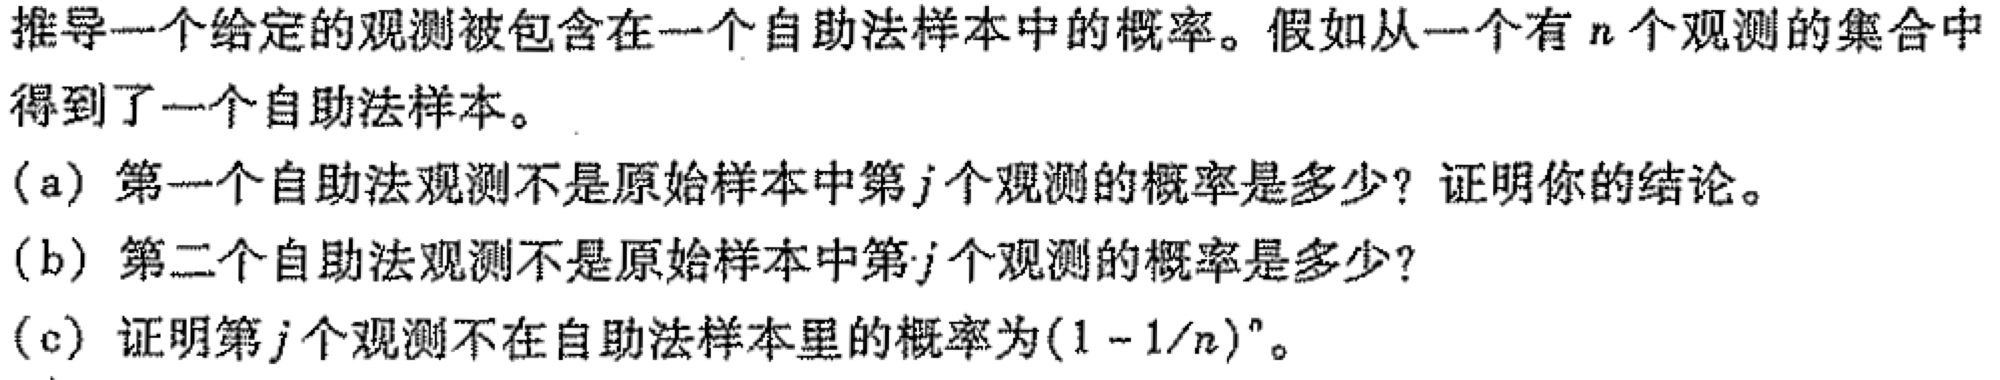

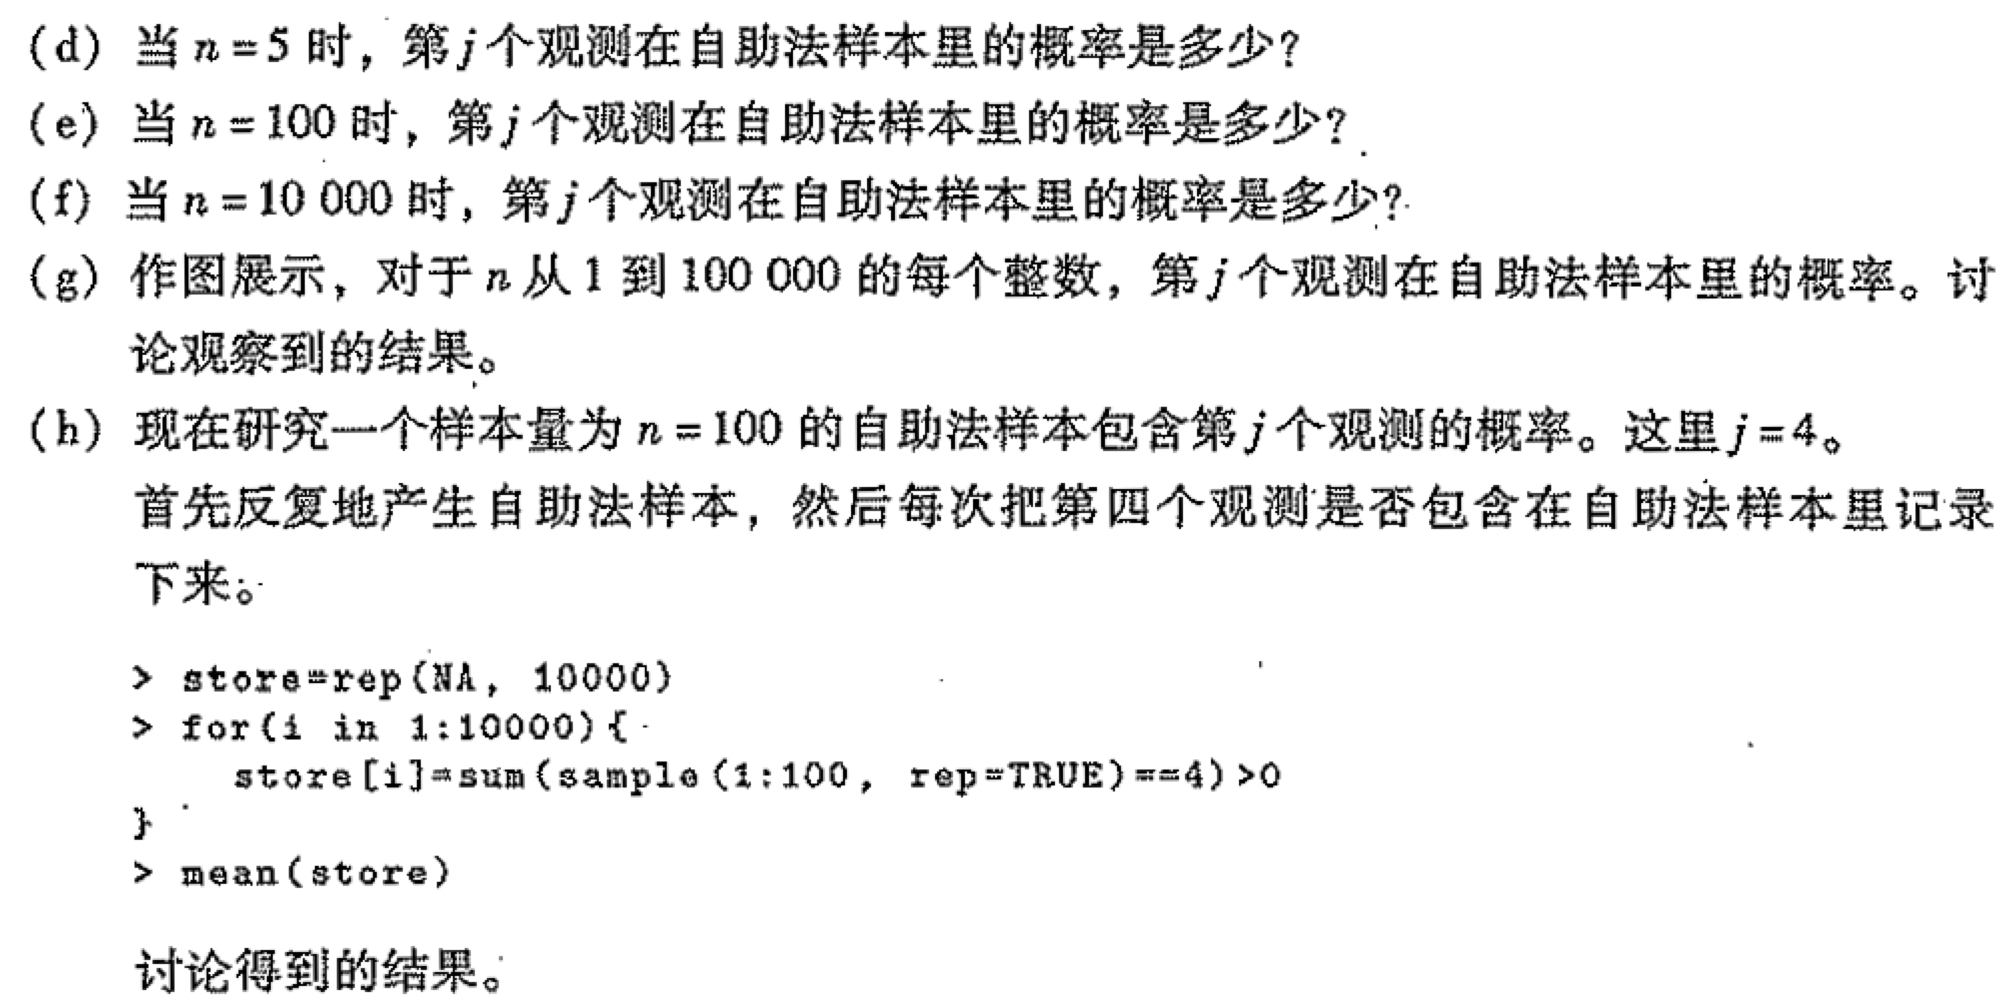

a. $\frac{n-1}{n}$

b. $\frac{n-1}{n}$

c. 
证明：第j个观测不在自助法观测第k个样本里的概率均为$\frac{n-1}{n}$，根据乘法法则，第j个观测不在所有自助法样本里的概率为$(1-\frac{1}{n})^{n}$

d.$1-(1-\frac{1}{5})^5$

e. $1-(1-\frac{1}{100})^{100}$

f. $1-(1-\frac{1}{10000})^{10000}$

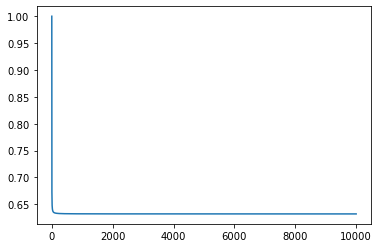

In [92]:
#g题
from scipy.special import comb
import matplotlib.pyplot as plt
numbers = np.arange(1,10001,1)
scores = []
for i in numbers:
    scores.append(1-(1-1/i)**i)
plt.plot(numbers,scores)

可见当n=1的时候，概率为1，之后慢慢收敛为0.632左右。

In [108]:
#h题
import random
number_set = np.arange(1,101).tolist()
count = 0
for i in range(100000):
    results = random.choices(population=number_set, k=100)
    if 4 in results:
        count+=1
print(count/100000)

0.63659


经过100000次的蒙特卡洛模拟，最终求得在n=100的自助法样本中，包含第4个观测的概率大约为0.637。

# 第四题

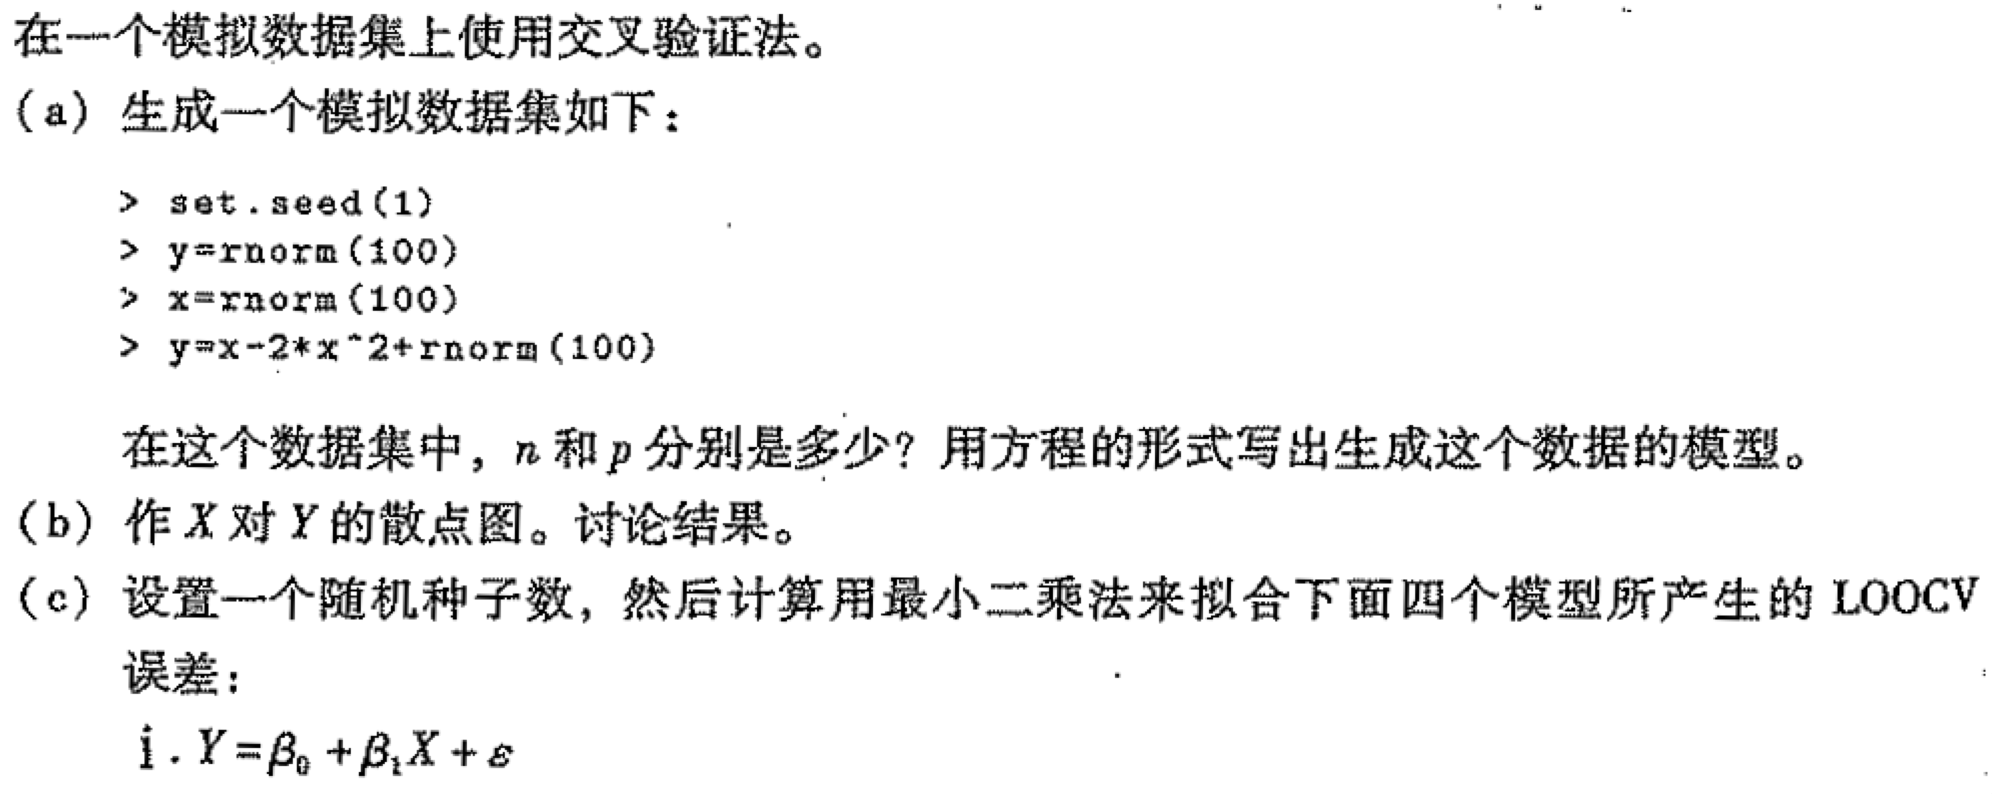

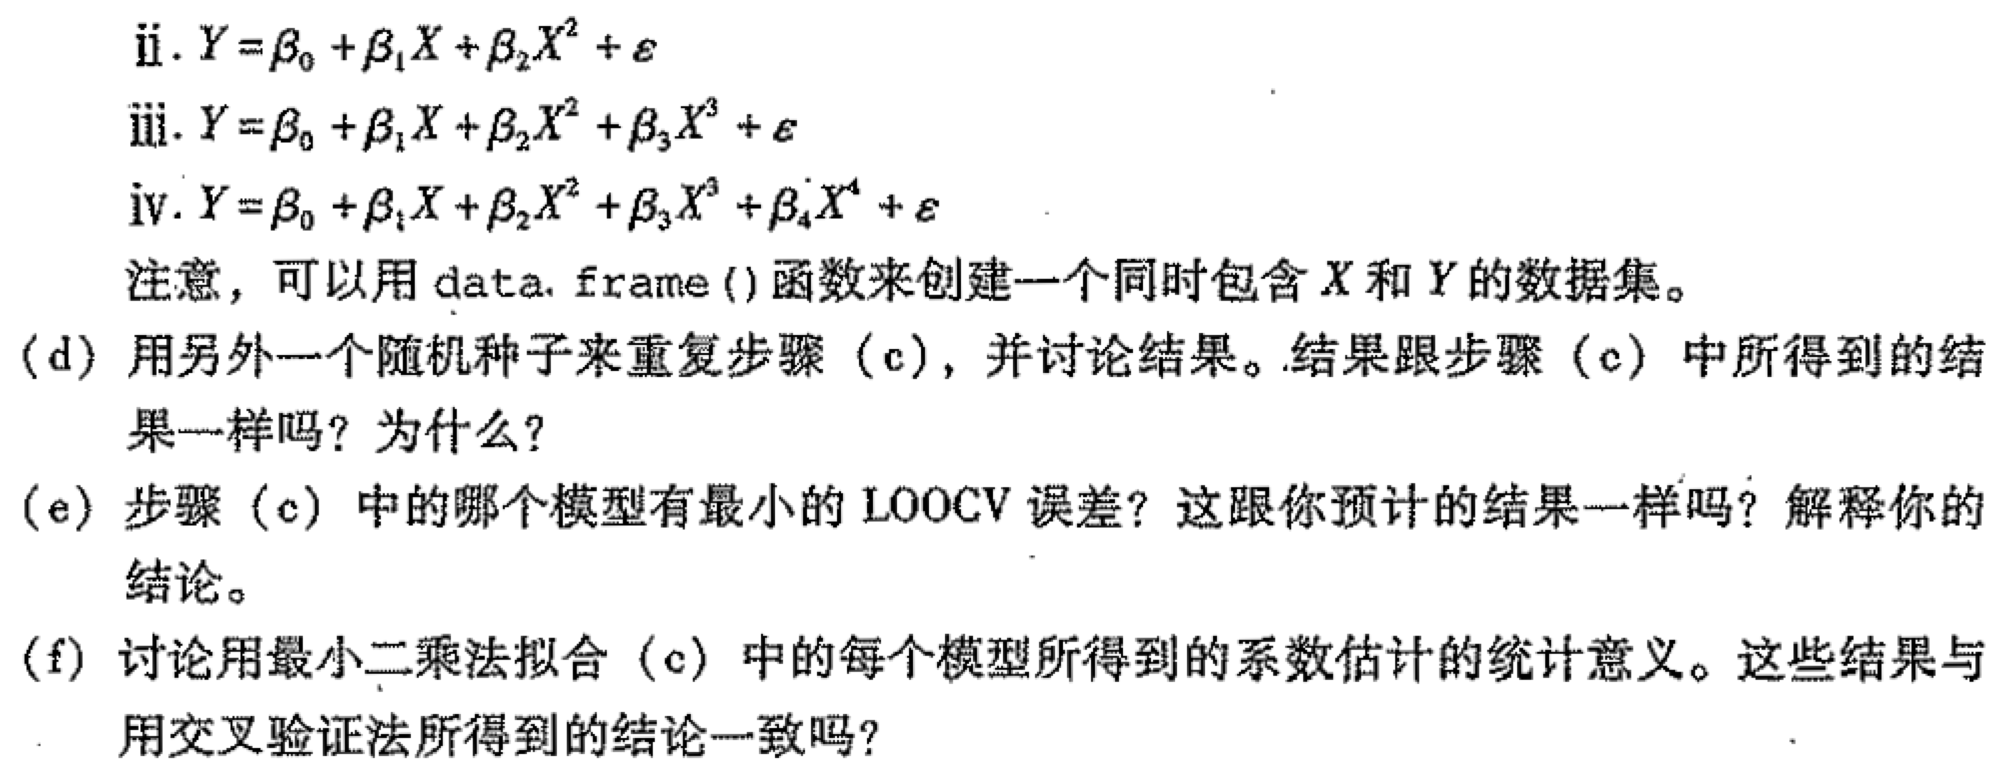

a

In [116]:
#随机数种子
import random
random.seed(1) 
import numpy as np
np.random.seed(1)

x = np.random.normal(0,1,100)
y = x-2*x**2+np.random.normal(0,1,100)

n=100,p=1,模型如下：$$y=x-2x^2+\epsilon$$

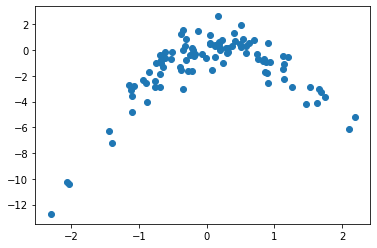

In [119]:
plt.scatter(x,y)

x对于y的散点图和一个标准正态分布的概率密度函数相似

# 第五题

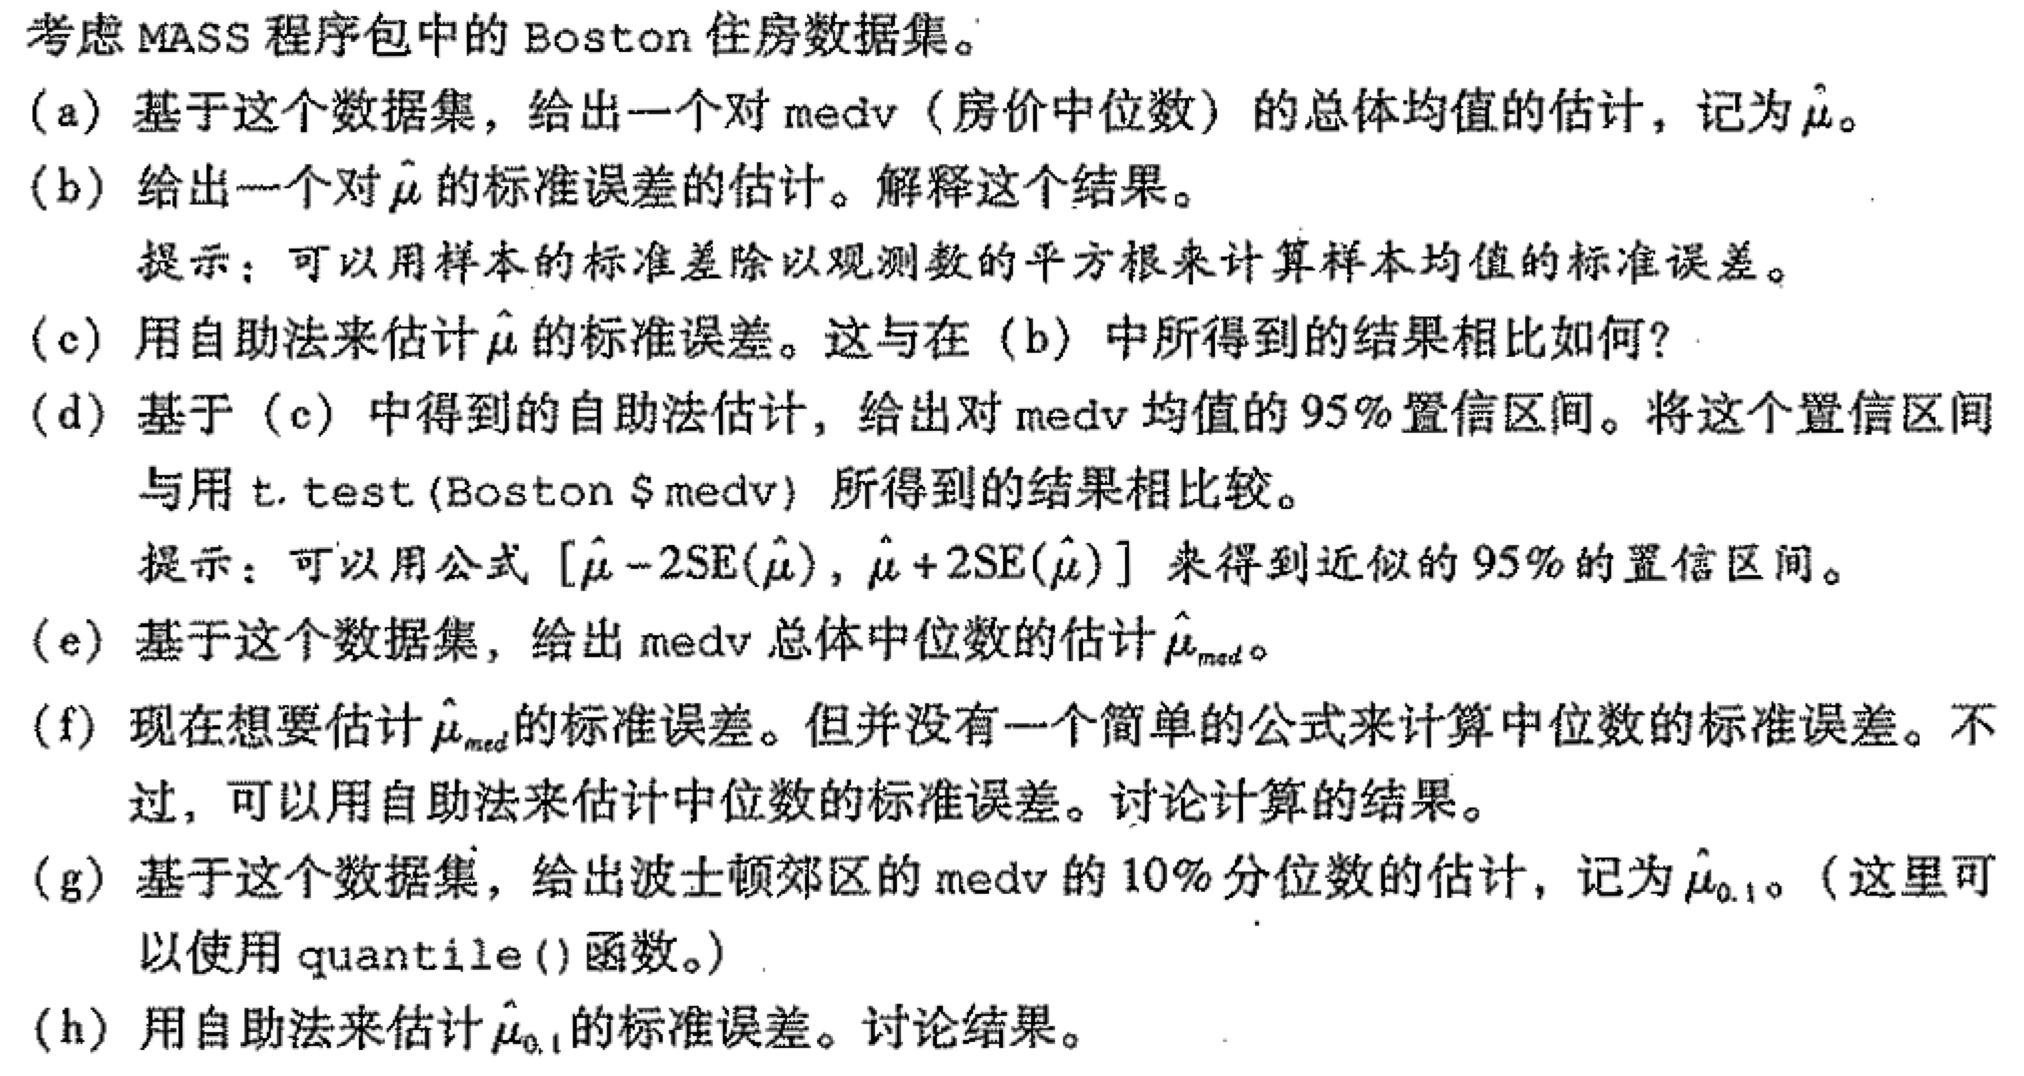

In [ ]:
#a.
library(MASS)
summary(Boston)

set.seed(1)
attach(Boston)
medv.mean=mean(medv);medv.mean
#得22.533

In [ ]:
#b
Medv.err=sd(medv)/sqrt(length(medv));Medv.err
#得0.4088611

In [ ]:
#c
Boot.fn=function(data,index)return (mean(data[index]))
library(boot)
Bstrap=boot(medv,Boot.fn,1000);Bstrap

Bootstrap Statistics :

    original      bias    std. error
    
t1* 22.53281 0.005601581   0.4060352

In [ ]:
#d
t.test(medv)
c(bstrap$t0-2*0.4107,bstrap$t0+2*0.4107)

One Sample t-test

data:  medv

t = 55.111, df = 505, p-value < 2.2e-16

alternative hypothesis: true mean is not equal to 0

95 percent confidence interval:

 21.72953 23.33608
 
sample estimates:

mean of x 

 22.53281 

In [ ]:
#e
Medv.med=median(medv);Medv.med
#得21.2